## Use of VFA methods
The goal of this notebook is to show if it is possible to use VFA linear methods in the Slimevolley gym environment.

In [2]:
from os.path import join
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import gym
import slimevolleygym
from slimevolleygym import SurvivalRewardEnv
from algorithms import *

plt.style.use('seaborn')

# Define our input folders and output files
DATADIR = join('..', 'data')
LOGDIR = join('..', 'logs')

We create a wrapper which inherits from gym.ObservationWrapper to transform the 12-dimensional original observation space to a reduced 8-dimensional space. This way we eliminate the information from the opponent, which is not relevant for the agent operation.

In [2]:
class ReducedDimension(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self._observation_space = gym.spaces.Box(shape=(8,), low=-2.0, high=2.0)
    def observation(self, obs):
        return obs[0:8]

slime_env = SurvivalRewardEnv(ReducedDimension(gym.make('SlimeVolley-v0')))

In [3]:
slime_env.observation_space

Box([-2. -2. -2. -2. -2. -2. -2. -2.], [2. 2. 2. 2. 2. 2. 2. 2.], (8,), float32)

We create the class BoundFeaturizer, which provides the definition of feature_vector. This allows to create a feature vector from a continuous observation space, given a number of partitions and a bound. We use radial base functions.

In [4]:
class BoundFeaturizer:
    def __init__(self, observation_space, partitions = 10, sigma = 0.1, bound = 5.0):
        self.n_dim = len(observation_space.low)
        self.sigma = sigma
        offset, scale_factor = [], []
        for i in range(self.n_dim):
            lower_bound = max(-1*bound, observation_space.low[i])
            upper_bound = min(bound, observation_space.high[i])
            offset.append(-1* lower_bound)
            scale_factor.append(1/(upper_bound - lower_bound))
        self.offset = np.array(offset, dtype=np.float_)
        self.scale_factor = np.array(scale_factor ,dtype=np.float_)
        scale = np.linspace(1.0/partitions,1.0,partitions) - 0.5/partitions
        self.landmarks = np.array(list(product(scale, repeat=self.n_dim)))
        self.n_parameters = partitions**self.n_dim
    
    def feature_vector(self, s):
        s = (s + self.offset) * self.scale_factor
        dist = (self.landmarks - s)**2
        f = np.exp(-dist.sum(axis=1)/(2*self.sigma**2))
        return f


In [5]:
featurizer = BoundFeaturizer(slime_env.observation_space, 3, sigma = 0.2, bound = 2.0)

##### Example: plot of feature vector from sampled states

In [6]:
ss_bsln = pd.read_csv(join(DATADIR, 'ss_bsln_900k.csv')).iloc[:, :8]
ss_random = pd.read_csv(join(DATADIR, 'ss_random_100k.csv')).iloc[:, :8]

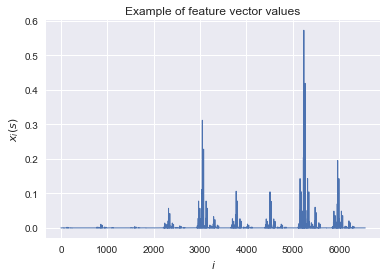

In [9]:
ss = pd.concat([ss_bsln, ss_random], ignore_index=True).sample(frac=1).to_numpy()
x = featurizer.feature_vector(ss[0, :])

fix, ax = plt.subplots()
ax.plot(x, linewidth=1)
ax.set_title('Example of feature vector values')
ax.set_ylabel('$x_i(s)$')
ax.set_xlabel('$i$');

In [14]:
def plot_results(rewards, lengths, title):
    rewards_avg = pd.DataFrame(rewards).expanding().mean()
    lengths_avg = pd.DataFrame(lengths).expanding().mean()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    ax1.set_title(title)

    ax1.plot(rewards, label='Reward per episode')
    ax1.plot(rewards_avg, label='Overall mean reward')
    ax1.set_xlabel('Episodes')
    ax1.set_ylabel('Reward')
    ax1.legend(loc='upper left')

    ax2.plot(lengths, label='Length per episode')
    ax2.plot(lengths_avg, label='Overall mean length')
    ax2.set_xlabel('Episodes')
    ax2.set_ylabel('Timesteps')
    ax2.legend(loc='upper left');
    

def save_results(rewards, lengths, file_name):
    training_data = np.vstack((rewards, lengths)).T
    np.savetxt(join(LOGDIR, file_name), training_data, delimiter=',',
               header='rewards,lengths', comments='')

### SARSA-LAMBDA

##### TEST 1: lambda = 0.99; alpha, epsilon = 0.1

In [46]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.99)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.1, alpha=0.1)

episodio 1: alfa = 0.0994077577396772, epsilon = 0.0994077577396772, rew_ep = 0.9400000000000046, len_ep = 594, total_t = 594
episodio 2: alfa = 0.09879530914999153, epsilon = 0.09879530914999153, rew_ep = 1.1800000000000008, len_ep = 618, total_t = 1212
episodio 3: alfa = 0.09815423743456443, epsilon = 0.09815423743456443, rew_ep = 2.5099999999999056, len_ep = 651, total_t = 1863
episodio 4: alfa = 0.0976324645002965, epsilon = 0.0976324645002965, rew_ep = 0.3300000000000034, len_ep = 533, total_t = 2396
episodio 5: alfa = 0.09718438429777657, epsilon = 0.09718438429777657, rew_ep = -0.39999999999999736, len_ep = 460, total_t = 2856
episodio 6: alfa = 0.09670837614715042, epsilon = 0.09670837614715042, rew_ep = -0.08999999999999697, len_ep = 491, total_t = 3347
episodio 7: alfa = 0.09622122749749973, epsilon = 0.09622122749749973, rew_ep = 0.05000000000000315, len_ep = 505, total_t = 3852
episodio 8: alfa = 0.09566858360625599, epsilon = 0.09566858360625599, rew_ep = 0.760000000000004

In [47]:
save_results(slime_rewards, slime_lengths, 'test1.csv')

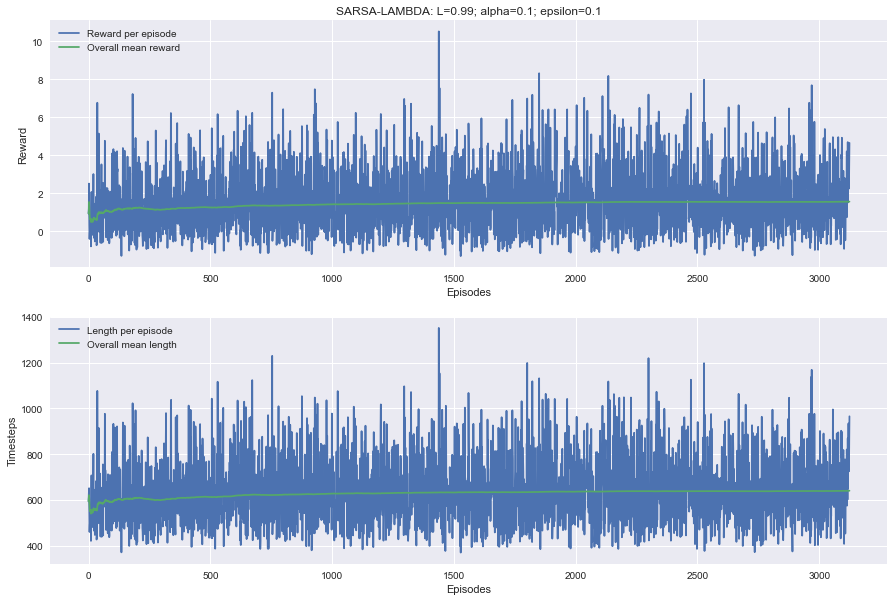

In [48]:
slime_info = pd.read_csv(join(LOGDIR, 'test1.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.99; alpha=0.1; epsilon=0.1")

##### TEST 2: lambda = 0.99; alpha, epsilon = 0.3

In [49]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.99)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.3, alpha=0.3)

episodio 1: alfa = 0.298193452233679, epsilon = 0.298193452233679, rew_ep = 2.039999999999921, len_ep = 604, total_t = 604
episodio 2: alfa = 0.2967002646740555, epsilon = 0.2967002646740555, rew_ep = 0.02000000000000335, len_ep = 502, total_t = 1106
episodio 3: alfa = 0.29501977587451766, epsilon = 0.29501977587451766, rew_ep = 0.6800000000000017, len_ep = 568, total_t = 1674
episodio 4: alfa = 0.2933546723058787, epsilon = 0.2933546723058787, rew_ep = 1.6599999999999417, len_ep = 566, total_t = 2240
episodio 5: alfa = 0.2920842654529853, epsilon = 0.2920842654529853, rew_ep = -0.6599999999999973, len_ep = 434, total_t = 2674
episodio 6: alfa = 0.2896497108027393, epsilon = 0.2896497108027393, rew_ep = 4.3699999999998544, len_ep = 837, total_t = 3511
episodio 7: alfa = 0.2880696444056754, epsilon = 0.2880696444056754, rew_ep = 0.4700000000000044, len_ep = 547, total_t = 4058
episodio 8: alfa = 0.28636930158973783, epsilon = 0.28636930158973783, rew_ep = 0.9199999999999962, len_ep = 59

In [50]:
save_results(slime_rewards, slime_lengths, 'test2.csv')

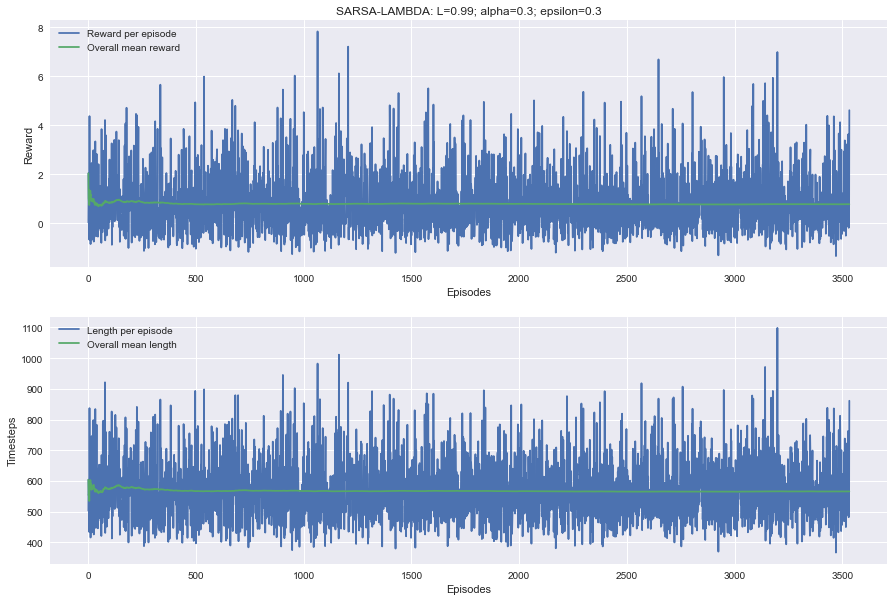

In [51]:
slime_info = pd.read_csv(join(LOGDIR, 'test2.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.99; alpha=0.3; epsilon=0.3")

##### TEST 3: lambda = 0.99; alpha, epsilon = 0.5

In [52]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.99)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.5, alpha=0.5)

episodio 1: alfa = 0.4976505256082468, epsilon = 0.4976505256082468, rew_ep = -0.28999999999999715, len_ep = 471, total_t = 471
episodio 2: alfa = 0.4950397431669804, epsilon = 0.4950397431669804, rew_ep = 0.2600000000000038, len_ep = 526, total_t = 997
episodio 3: alfa = 0.4925362309178397, epsilon = 0.4925362309178397, rew_ep = 0.07000000000000384, len_ep = 507, total_t = 1504
episodio 4: alfa = 0.4891787619450452, epsilon = 0.4891787619450452, rew_ep = 1.8399999999999468, len_ep = 684, total_t = 2188
episodio 5: alfa = 0.4869142189695109, epsilon = 0.4869142189695109, rew_ep = -0.359999999999997, len_ep = 464, total_t = 2652
episodio 6: alfa = 0.4842290013822017, epsilon = 0.4842290013822017, rew_ep = 0.530000000000004, len_ep = 553, total_t = 3205
episodio 7: alfa = 0.4819921921310371, epsilon = 0.4819921921310371, rew_ep = -0.36999999999999733, len_ep = 463, total_t = 3668
episodio 8: alfa = 0.47915200509418765, epsilon = 0.47915200509418765, rew_ep = 0.9100000000000001, len_ep = 

In [53]:
save_results(slime_rewards, slime_lengths, 'test3.csv')

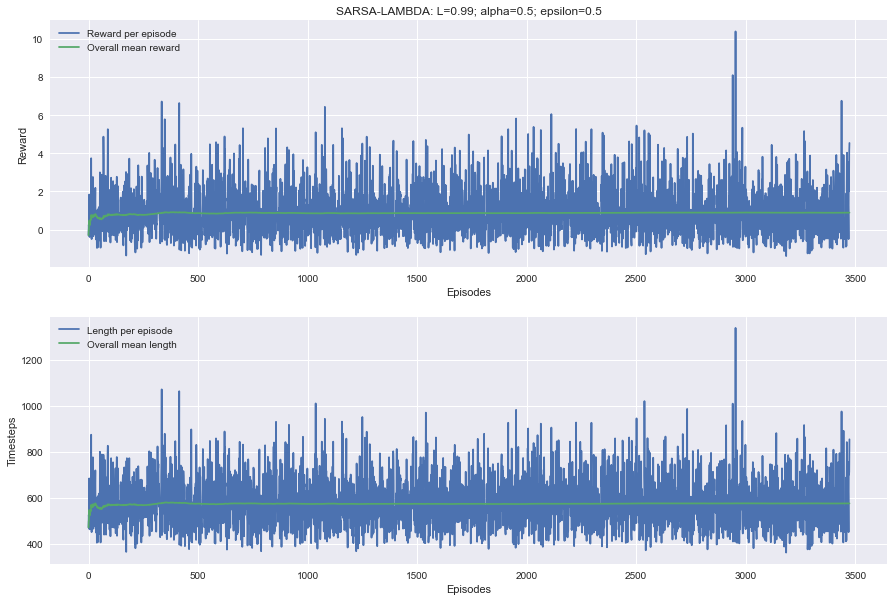

In [54]:
slime_info = pd.read_csv(join(LOGDIR, 'test3.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.99; alpha=0.5; epsilon=0.5")

##### TEST 4: lambda = 0.9; alpha, epsilon = 0.1

In [11]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.9)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.1, alpha=0.1)

episodio 1: alfa = 0.09955299979308689, epsilon = 0.09955299979308689, rew_ep = -0.5199999999999974, len_ep = 448, total_t = 448
episodio 2: alfa = 0.09912385630560178, epsilon = 0.09912385630560178, rew_ep = -0.6799999999999975, len_ep = 432, total_t = 880
episodio 3: alfa = 0.09857918308674173, epsilon = 0.09857918308674173, rew_ep = 0.5100000000000042, len_ep = 551, total_t = 1431
episodio 4: alfa = 0.09801201621448068, epsilon = 0.09801201621448068, rew_ep = 0.7700000000000038, len_ep = 577, total_t = 2008
episodio 5: alfa = 0.09740914084315393, epsilon = 0.09740914084315393, rew_ep = 1.16999999999999, len_ep = 617, total_t = 2625
episodio 6: alfa = 0.09681675074875674, epsilon = 0.09681675074875674, rew_ep = 1.1000000000000008, len_ep = 610, total_t = 3235
episodio 7: alfa = 0.09613466691805234, epsilon = 0.09613466691805234, rew_ep = 2.0699999999999807, len_ep = 707, total_t = 3942
episodio 8: alfa = 0.0955997266732451, epsilon = 0.0955997266732451, rew_ep = 0.5800000000000047, l

In [12]:
save_results(slime_rewards, slime_lengths, 'test4.csv')

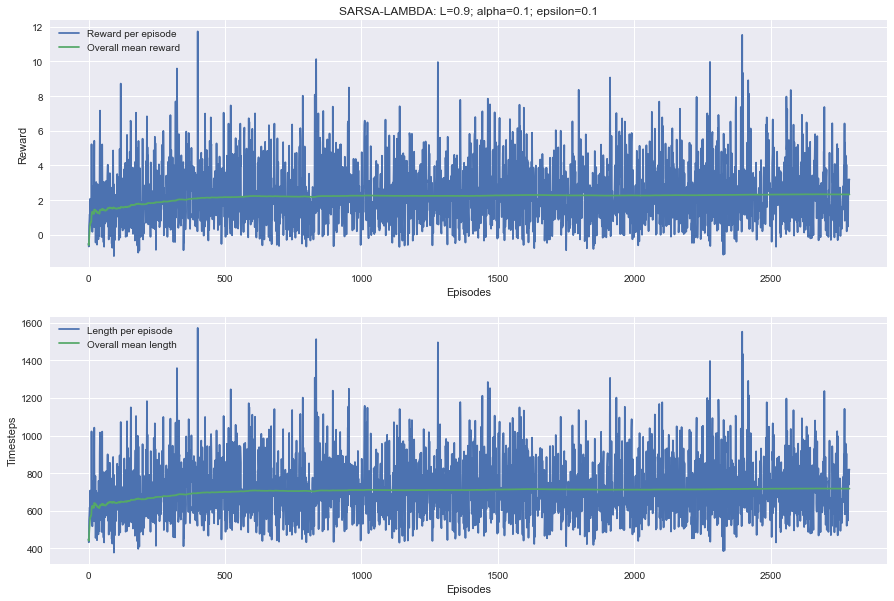

In [44]:
slime_info = pd.read_csv(join(LOGDIR, 'test4.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.9; alpha=0.1; epsilon=0.1")

##### TEST 5: lambda = 0.9; alpha, epsilon = 0.3

In [16]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.9)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.3, alpha=0.3)

episodio 1: alfa = 0.2985007512578054, epsilon = 0.2985007512578054, rew_ep = 0.01000000000000334, len_ep = 501, total_t = 501
episodio 2: alfa = 0.2969080286070406, epsilon = 0.2969080286070406, rew_ep = 0.3500000000000041, len_ep = 535, total_t = 1036
episodio 3: alfa = 0.2952175063453176, epsilon = 0.2952175063453176, rew_ep = 0.7100000000000033, len_ep = 571, total_t = 1607
episodio 4: alfa = 0.29378034724885005, epsilon = 0.29378034724885005, rew_ep = -0.11999999999999589, len_ep = 488, total_t = 2095
episodio 5: alfa = 0.29220988932244607, epsilon = 0.29220988932244607, rew_ep = 0.36000000000000365, len_ep = 536, total_t = 2631
episodio 6: alfa = 0.29062166931524547, epsilon = 0.29062166931524547, rew_ep = 0.4500000000000042, len_ep = 545, total_t = 3176
episodio 7: alfa = 0.2892676235071363, epsilon = 0.2892676235071363, rew_ep = -0.3299999999999973, len_ep = 467, total_t = 3643
episodio 8: alfa = 0.2877558179906076, epsilon = 0.2877558179906076, rew_ep = 0.24000000000000377, le

In [17]:
save_results(slime_rewards, slime_lengths, 'test5.csv')

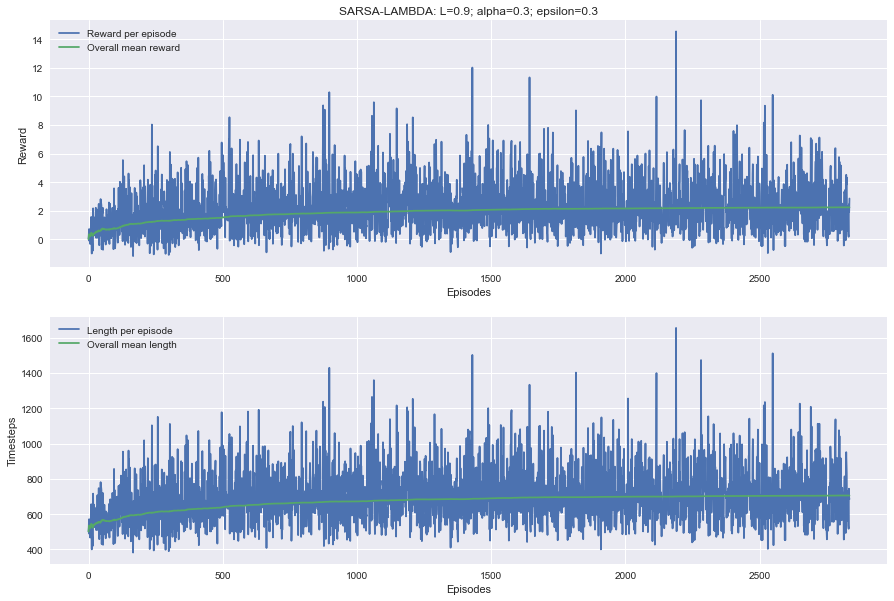

In [43]:
slime_info = pd.read_csv(join(LOGDIR, 'test5.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.9; alpha=0.3; epsilon=0.3")

##### TEST 6: lambda = 0.9; alpha, epsilon = 0.5

In [19]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.9)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.5, alpha=0.5)

episodio 1: alfa = 0.49757588325450997, epsilon = 0.49757588325450997, rew_ep = -0.1399999999999969, len_ep = 486, total_t = 486
episodio 2: alfa = 0.49484671434506733, epsilon = 0.49484671434506733, rew_ep = 0.5000000000000042, len_ep = 550, total_t = 1036
episodio 3: alfa = 0.4916504587074719, epsilon = 0.4916504587074719, rew_ep = 1.4799999999999949, len_ep = 648, total_t = 1684
episodio 4: alfa = 0.4886702779477104, epsilon = 0.4886702779477104, rew_ep = 1.0800000000000025, len_ep = 608, total_t = 2292
episodio 5: alfa = 0.48631567966461325, epsilon = 0.48631567966461325, rew_ep = -0.16999999999999726, len_ep = 483, total_t = 2775
episodio 6: alfa = 0.48375468704126207, epsilon = 0.48375468704126207, rew_ep = 0.28000000000000314, len_ep = 528, total_t = 3303
episodio 7: alfa = 0.48090411432747004, epsilon = 0.48090411432747004, rew_ep = 0.9100000000000046, len_ep = 591, total_t = 3894
episodio 8: alfa = 0.4786970245644138, epsilon = 0.4786970245644138, rew_ep = -0.39999999999999736

In [20]:
save_results(slime_rewards, slime_lengths, 'test6.csv')

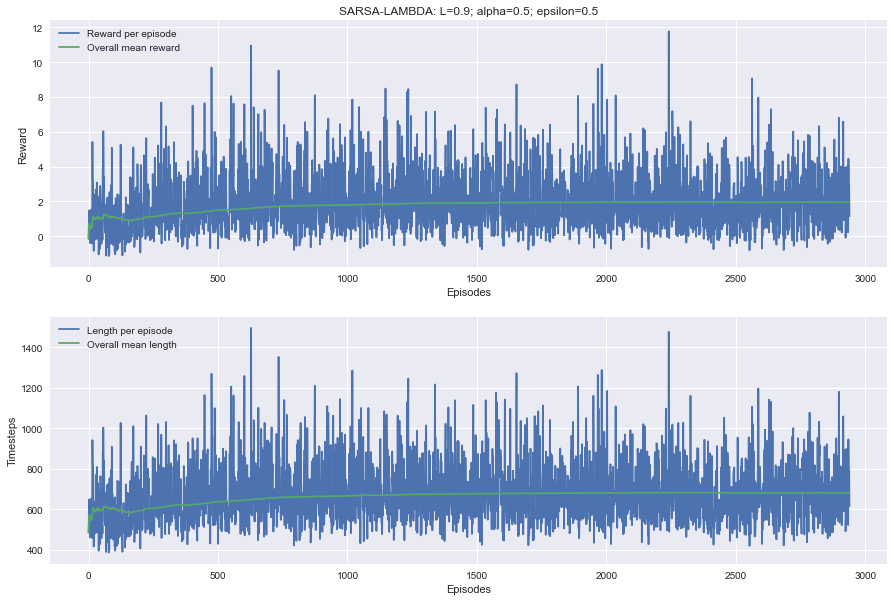

In [42]:
slime_info = pd.read_csv(join(LOGDIR, 'test6.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.9; alpha=0.5; epsilon=0.5")

##### TEST 7: lambda = 0.7; alpha, epsilon = 0.1

In [22]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.7)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.1, alpha=0.1)

episodio 1: alfa = 0.09951418149913535, epsilon = 0.09951418149913535, rew_ep = -0.12999999999999667, len_ep = 487, total_t = 487
episodio 2: alfa = 0.09909709634335684, epsilon = 0.09909709634335684, rew_ep = -0.7999999999999976, len_ep = 420, total_t = 907
episodio 3: alfa = 0.09846883565604322, epsilon = 0.09846883565604322, rew_ep = 1.3599999999999952, len_ep = 636, total_t = 1543
episodio 4: alfa = 0.09790524078610954, epsilon = 0.09790524078610954, rew_ep = 1.7399999999999773, len_ep = 574, total_t = 2117
episodio 5: alfa = 0.09736142181766148, epsilon = 0.09736142181766148, rew_ep = 0.5700000000000047, len_ep = 557, total_t = 2674
episodio 6: alfa = 0.09665230127189621, epsilon = 0.09665230127189621, rew_ep = 2.309999999999893, len_ep = 731, total_t = 3405
episodio 7: alfa = 0.09624047376379309, epsilon = 0.09624047376379309, rew_ep = -0.7299999999999975, len_ep = 427, total_t = 3832
episodio 8: alfa = 0.09570877305151075, epsilon = 0.09570877305151075, rew_ep = 0.54000000000000

In [23]:
save_results(slime_rewards, slime_lengths, 'test7.csv')

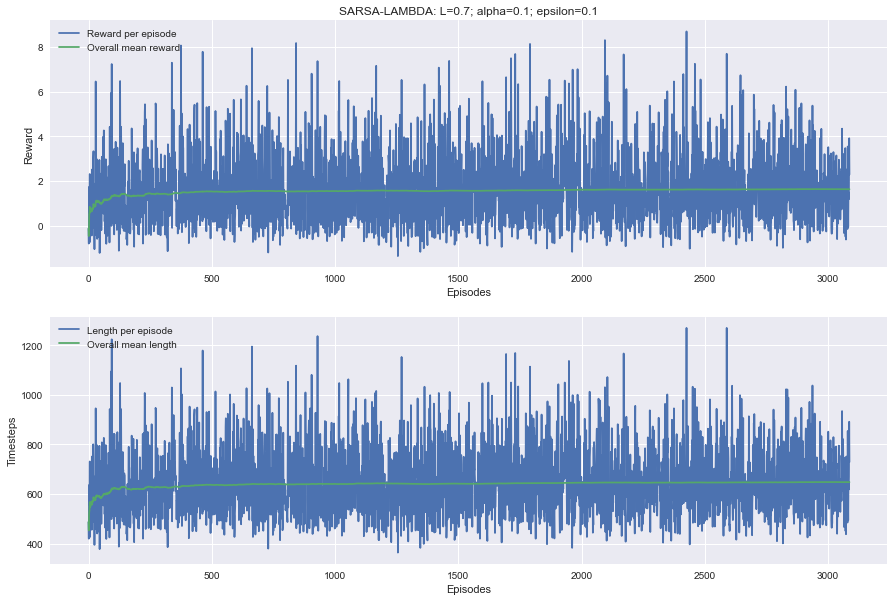

In [41]:
slime_info = pd.read_csv(join(LOGDIR, 'test7.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.7; alpha=0.1; epsilon=0.1")

##### TEST 8: lambda = 0.7; alpha, epsilon = 0.3

In [25]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.7)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.3, alpha=0.3)

episodio 1: alfa = 0.29846194848836255, epsilon = 0.29846194848836255, rew_ep = 0.14000000000000323, len_ep = 514, total_t = 514
episodio 2: alfa = 0.2968308421683421, epsilon = 0.2968308421683421, rew_ep = 0.4800000000000042, len_ep = 548, total_t = 1062
episodio 3: alfa = 0.2950168256767589, epsilon = 0.2950168256767589, rew_ep = 1.129999999999977, len_ep = 613, total_t = 1675
episodio 4: alfa = 0.2935454157815094, epsilon = 0.2935454157815094, rew_ep = 0.9999999999999996, len_ep = 500, total_t = 2175
episodio 5: alfa = 0.29212516031719693, epsilon = 0.29212516031719693, rew_ep = -0.14999999999999636, len_ep = 485, total_t = 2660
episodio 6: alfa = 0.29086589529915396, epsilon = 0.29086589529915396, rew_ep = -0.6799999999999975, len_ep = 432, total_t = 3092
episodio 7: alfa = 0.2894846566872024, epsilon = 0.2894846566872024, rew_ep = -0.23999999999999688, len_ep = 476, total_t = 3568
episodio 8: alfa = 0.28789685359750355, epsilon = 0.28789685359750355, rew_ep = 0.5000000000000038, l

In [26]:
save_results(slime_rewards, slime_lengths, 'test8.csv')

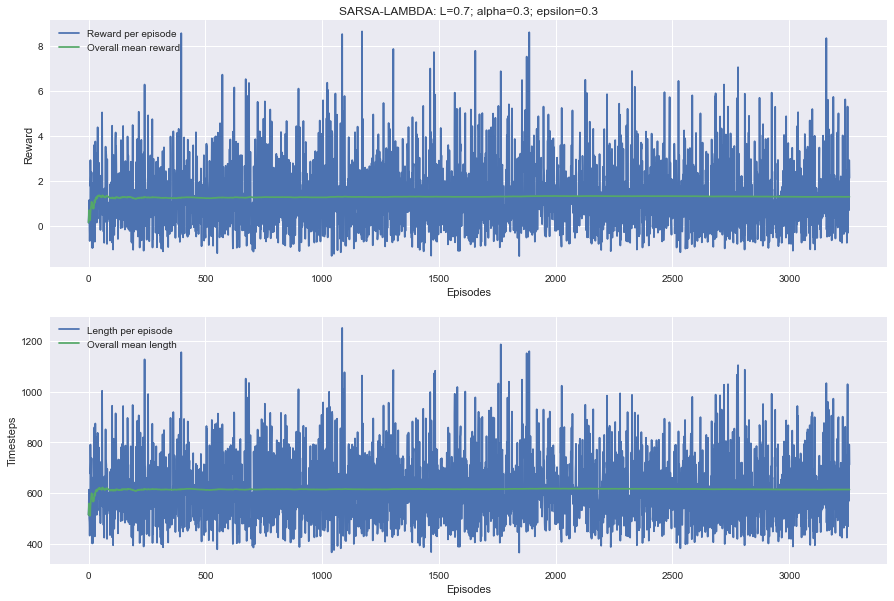

In [39]:
slime_info = pd.read_csv(join(LOGDIR, 'test8.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.7; alpha=0.3; epsilon=0.3")

##### TEST 9: lambda = 0.7; alpha, epsilon = 0.5

In [28]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.7)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.5, alpha=0.5)

episodio 1: alfa = 0.4966611808400969, epsilon = 0.4966611808400969, rew_ep = 1.6999999999999773, len_ep = 670, total_t = 670
episodio 2: alfa = 0.49435705607041125, epsilon = 0.49435705607041125, rew_ep = -0.349999999999997, len_ep = 465, total_t = 1135
episodio 3: alfa = 0.4912179944536666, epsilon = 0.4912179944536666, rew_ep = 1.3699999999999555, len_ep = 637, total_t = 1772
episodio 4: alfa = 0.4888608974776007, epsilon = 0.4888608974776007, rew_ep = -0.18999999999999728, len_ep = 481, total_t = 2253
episodio 5: alfa = 0.48611633010865385, epsilon = 0.48611633010865385, rew_ep = 0.6300000000000043, len_ep = 563, total_t = 2816
episodio 6: alfa = 0.48264332426137413, epsilon = 0.48264332426137413, rew_ep = 2.1699999999999333, len_ep = 717, total_t = 3533
episodio 7: alfa = 0.4799576610525429, epsilon = 0.4799576610525429, rew_ep = 0.5800000000000047, len_ep = 558, total_t = 4091
episodio 8: alfa = 0.4767622125797882, epsilon = 0.4767622125797882, rew_ep = 2.679999999999951, len_ep 

In [29]:
save_results(slime_rewards, slime_lengths, 'test9.csv')

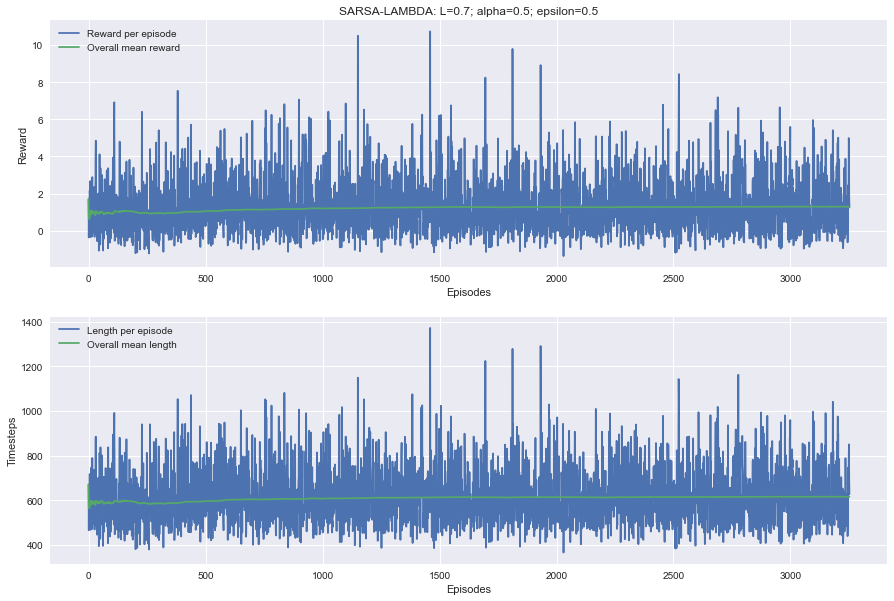

In [38]:
slime_info = pd.read_csv(join(LOGDIR, 'test9.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.7; alpha=0.5; epsilon=0.5")

#### Results

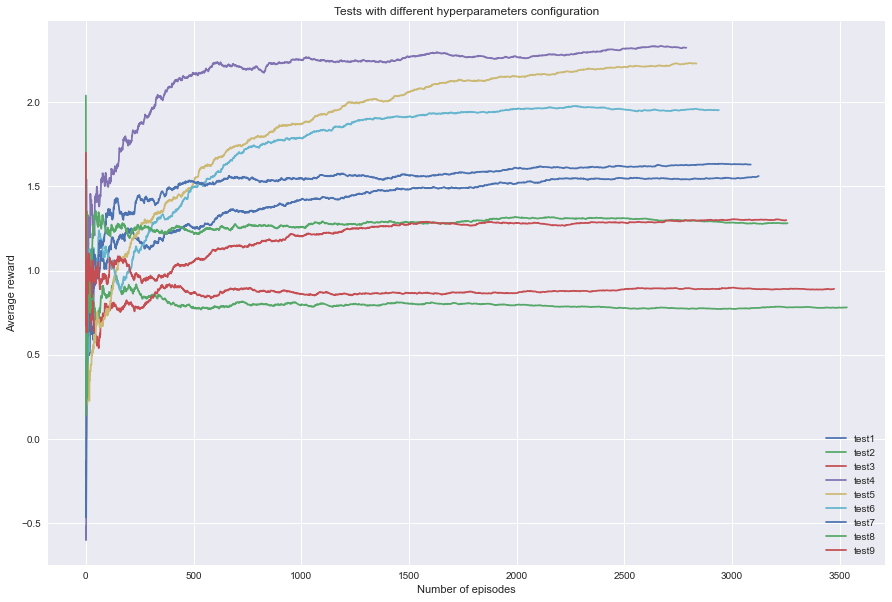

In [8]:
slime_avg_rews = pd.DataFrame({
    "test1": pd.read_csv(join(LOGDIR, 'test1.csv')).loc[:, 'rewards'].expanding().mean(),
    "test2": pd.read_csv(join(LOGDIR, 'test2.csv')).loc[:, 'rewards'].expanding().mean(),
    "test3": pd.read_csv(join(LOGDIR, 'test3.csv')).loc[:, 'rewards'].expanding().mean(),
    "test4": pd.read_csv(join(LOGDIR, 'test4.csv')).loc[:, 'rewards'].expanding().mean(),
    "test5": pd.read_csv(join(LOGDIR, 'test5.csv')).loc[:, 'rewards'].expanding().mean(),
    "test6": pd.read_csv(join(LOGDIR, 'test6.csv')).loc[:, 'rewards'].expanding().mean(),
    "test7": pd.read_csv(join(LOGDIR, 'test7.csv')).loc[:, 'rewards'].expanding().mean(),
    "test8": pd.read_csv(join(LOGDIR, 'test8.csv')).loc[:, 'rewards'].expanding().mean(),
    "test9": pd.read_csv(join(LOGDIR, 'test9.csv')).loc[:, 'rewards'].expanding().mean()
})

fig, ax = plt.subplots(figsize=(15, 10))

for i in range(slime_avg_rews.shape[1]):
    ax.plot(slime_avg_rews.iloc[:, i], label='test'+str(i+1))
    
ax.legend(loc='lower right')
ax.set_title('Tests with different hyperparameters configuration')
ax.set_xlabel('Number of episodes')
ax.set_ylabel('Average reward');

### ACTOR-CRITIC (LAMBDA)

##### TEST 10: lambda_actor/critic = X; alpha = X; beta = X

In [23]:
pi = LambdaPolicyEstimatorAC(featurizer, slime_env.action_space.n, L=0.5)   # L_actor
v = LambdaValueFunctionAC(featurizer, L=0.5)     #L_critic
slime_pi, slime_rewards, slime_lengths, best_p = actor_critic_lambda(slime_env, pi, v, 2_000_000, \
                                                                alpha=0.001, beta=0.005, gamma = 0.99)

episodio 1: alpha = 0.0009712700550879236, beta = 0.004856350275439606, rew_ep = -0.3750768562205746, len_ep = 583, total_t = 583 
episodio 2: alpha = 0.0009430825456283714, beta = 0.004715412728141852, rew_ep = -0.44793485911722264, len_ep = 589, total_t = 1172 
episodio 3: alpha = 0.0009203952571926862, beta = 0.004601976285963421, rew_ep = -0.6055704341167998, len_ep = 487, total_t = 1659 
episodio 4: alpha = 0.0008856326449127205, beta = 0.004428163224563578, rew_ep = 0.037051436453699946, len_ep = 770, total_t = 2429 
episodio 5: alpha = 0.0008585126928167269, beta = 0.004292563464083602, rew_ep = -0.6362137171631719, len_ep = 622, total_t = 3051 
episodio 6: alpha = 0.0008294398586157613, beta = 0.004147199293078763, rew_ep = -0.1572541151016951, len_ep = 689, total_t = 3740 
episodio 7: alpha = 0.0008120809887750185, beta = 0.004060404943875036, rew_ep = -0.7173986924985343, len_ep = 423, total_t = 4163 
episodio 8: alpha = 0.0007810187053196672, beta = 0.0039050935265982785, re

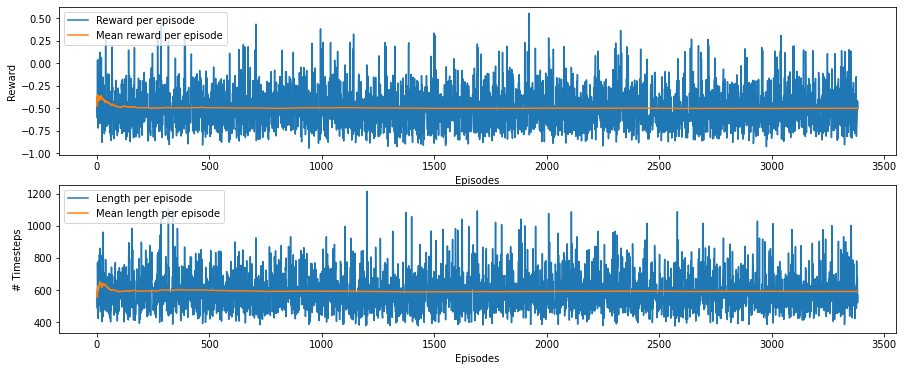

In [24]:
plot_vfa_results(slime_rewards, slime_lengths)